# Sprawozdanie z zajęć nr 10
### Mateusz Stelmaszek
### 80275

# Przygotowujemy środowisko !

In [6]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-pej2ycfp
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-pej2ycfp
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


# Należy pamiętać, aby podczas kompilowania kodu GPU zmienić środowisko!
    Środowisko wykonawcze -> Zmień typ środowiska wykonawczego -> GPU

# Poniżej 2 kody działające odpowiednio na CPU oraz GPU które generują fraktal oraz plik .jpg pozwalający go odpalić
# CPU - procesor 
# GPU - karta graficzna
# Poznajmy podstawy które są zastosowane w programach !

1. %%cu - pozwala na kompilowanie poniższych kodów CUDA w środowisku GoogleCollab
2. cuComplex to struktura która poprzez przeciążanie operatorów '*' oraz '+' mnoży oraz dodaje wyimaginowane liczby
3. Funkcja mandelbrot 2 to funkcja typu boolean zwraca tylko 2 wartości '0' lub '1' w zależności od tego czy punkt znajduje się w zbiorze mandelbrota
4. Dzięki funkcji kernel liczby wartość pikseli poprzez iteracje
5. offset - przenoszenie wartości RGB (kolory)
6. Fukcja main to w niej wywołujemy fukcję oraz liczymy czas wykonania programu
# do programu GPU warto dodać że x i y zmiennej blockldx to indeksy bloku o wymiarach x,y i pozwalają nam na identyfikacje bloku wątków i obliczenie jego położenia w siatce

# CPU

In [5]:
%%cu
#include<stdio.h>
#include <time.h>
#define DIM 5000
struct cuComplex {
    float   r;
    float   i;
    cuComplex( float a, float b ) : r(a), i(b)  {}
    float magnitude2( void ) { return r * r + i * i; }
    cuComplex operator*(const cuComplex& a) {
        return cuComplex(r*a.r - i*a.i, i*a.r + r*a.i);
    }
    cuComplex operator+(const cuComplex& a) {
        return cuComplex(r+a.r, i+a.i);
    }
};
int mandel(double x, double y) {
    const float scale = 1.5;
    float jx = scale * (float)(DIM/2 - x)/(DIM/2);
    float jy = scale * (float)(DIM/2 - y)/(DIM/2);
    cuComplex c(jx, jy);
    cuComplex z(0, 0);
    for (int i = 0; i < 200; i++) {
    z = z * z + c;
      if (z.magnitude2() > 1000) {
        return 0;
    }
  }
  return 1;
}
void kernel( unsigned char *ptr ){
    for (int y=0; y<DIM; y++) {
        for (int x=0; x<DIM; x++) {
            int offset = x + y * DIM;
            int mandelbrotValue = mandel( x, y );
            ptr[offset*4 + 0] = 19;
            ptr[offset*4 + 1] = 255 * mandelbrotValue ;
            ptr[offset*4 + 2] = 72;
            ptr[offset*4 + 3] = 200;
        }
    }
 }
struct DataBlock{
    unsigned char *dev_bitmap; 
};
void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("MandelbrotCPU.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}
int main( void ) {
    FILE *fp = fopen("mandelcpu5000.txt", "w");
    clock_t start_time = clock();
    DataBlock data ; 
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM * DIM * 4 ;
    kernel(bitmap);
    save_to_file(bitmap);
    clock_t end_time = clock();
    double elapsed_time = (double)(end_time - start_time) / CLOCKS_PER_SEC * 1000;
    printf("milliseconds %f \n", elapsed_time);
    long milliseconds = elapsed_time ; 
    long seconds = milliseconds / 1000.0;
    fprintf(fp, "%f\n", seconds);
    fclose(fp);
    return 0;

}

milliseconds 40128.995000 



#GPU (Trzeba zmienić środowisko!)

In [6]:
%%cu
#include<stdio.h>
#define DIM 5000
#include <cuda_runtime.h>
struct cuComplex {
    float   r;
    float   i;
    // cuComplex( float a, float b ) : r(a), i(b)  {}
    __device__ cuComplex( float a, float b ) : r(a), i(b) {}
    __device__ float magnitude2( void ) {
        return r * r + i * i;
    }
    __device__ cuComplex operator*(const cuComplex& a) {
        return cuComplex(r*a.r - i*a.i, i*a.r + r*a.i);
    }
    __device__ cuComplex operator+(const cuComplex& a) {
        return cuComplex(r+a.r, i+a.i);
    }
};
__device__ int mandel(double x, double y) {
    const float scale = 1.5;
    float jx = scale * (float)(DIM/2 - x)/(DIM/2);
    float jy = scale * (float)(DIM/2 - y)/(DIM/2);
    cuComplex c(jx, jy);
    cuComplex z(0, 0);
    for (int i = 0; i < 200; i++) {
    z = z * z + c;
      if (z.magnitude2() > 1000) {
        return 0;
    }
  }
  return 1;
}
__global__ void kernel( unsigned char *ptr ) {
    int x = blockIdx.x;
    int y = blockIdx.y;
    int offset = x + y * gridDim.x;
    int man =  mandel( x, y );
    ptr[offset*4 + 0] = 150;
    ptr[offset*4 + 1] = 220;
    ptr[offset*4 + 2] = 177 * man;
    ptr[offset*4 + 3] = 12;
}
struct DataBlock {
    unsigned char   *dev_bitmap;
};
void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("MandelbrotGPU.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}
int main( void ) {
    FILE *fp = fopen("mandelgpu5000.txt", "w");
    cudaEvent_t start, end;
    cudaEventCreate(&start);
    cudaEventCreate(&end);
    cudaEventRecord(start, 0);
    DataBlock data ; 
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM * DIM * 4 ;
    unsigned char *dev_bitmap;
    cudaMalloc((void**)&dev_bitmap,image_size);
    data.dev_bitmap = dev_bitmap ;
    dim3 grid(DIM,DIM);
    kernel<<<grid,1>>>(dev_bitmap);
    cudaMemcpy(bitmap,dev_bitmap,image_size,cudaMemcpyDeviceToHost) ;   
    cudaFree(dev_bitmap);
    save_to_file(bitmap);
    cudaEventRecord(end, 0);
    cudaEventSynchronize(end);
    float elapsed_time;
    cudaEventElapsedTime(&elapsed_time, start, end);
    printf("czas wykonywania: %f milliseconds\n", elapsed_time);
    fprintf(fp, "%f\n", elapsed_time);
    fclose(fp);
    cudaEventDestroy(start);
    cudaEventDestroy(end);


}

czas wykonywania: 4080.088623 milliseconds



# Porównanie

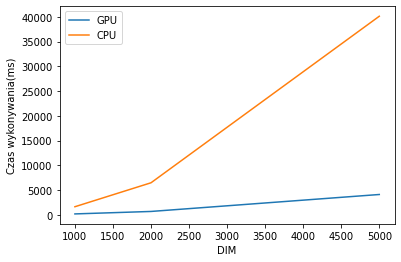

In [7]:
import matplotlib.pyplot as plt
czasgpu = [153.596100,652.561523,4080.088623]
czascpu = [1608.207000,6451.048000,40128.995000 ]
DIM = [ 1000 , 2000 , 5000 ]

plt.plot(DIM,czasgpu, label="GPU")
plt.plot(DIM,czascpu, label="CPU")
plt.xlabel("DIM")
plt.ylabel("Czas wykonywania(ms)")
plt.legend()
plt.show()